In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import sqlite3 as sql
import os
import pandas as pd
from datetime import datetime
from glob import glob
import sklearn as sk
import sklearn.linear_model

os.sys.path.append('../')
import PlaceCellAnalysis as pc
import utilities as u
import preprocessing as pp
import behavior as b
import BayesianDecoding as bd


%load_ext autoreload
%autoreload 2

%matplotlib inline

C:\Users\mplitt\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# load session
mouse = '4139224.3'
df = pp.load_session_db()


#df = df[df['RewardCount']>30]
df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])

df_mouse = df[df['MouseName'].str.match(mouse)]
df_mouse = df_mouse[df_mouse['Track'].str.match('TwoTower_noTimeout') | df_mouse['Track'].str.match('TwoTower_Timeout')]
df_mouse

,MouseName,DateFolder,SessionNumber,Track,RewardCount,Imaging,ImagingRegion,DateTime,data file,scanfile,scanmat
823,4139224.3,18_10_2018,1,TwoTower_noTimeout,61,1,CA1,2018-10-18,G:\My Drive\\VR_Data\TwoTower\4139224.3\18_10_...,G:\My Drive\2P_Data\TwoTower\4139224.3\18_10_2...,G:\My Drive\2P_Data\TwoTower\4139224.3\18_10_2...
825,4139224.3,18_10_2018,3,TwoTower_noTimeout,41,1,CA1,2018-10-18,G:\My Drive\\VR_Data\TwoTower\4139224.3\18_10_...,G:\My Drive\2P_Data\TwoTower\4139224.3\18_10_2...,G:\My Drive\2P_Data\TwoTower\4139224.3\18_10_2...
859,4139224.3,20_10_2018,2,TwoTower_noTimeout,60,1,CA1,2018-10-20,G:\My Drive\\VR_Data\TwoTower\4139224.3\20_10_...,G:\My Drive\2P_Data\TwoTower\4139224.3\20_10_2...,G:\My Drive\2P_Data\TwoTower\4139224.3\20_10_2...
897,4139224.3,23_10_2018,1,TwoTower_Timeout,48,1,CA1,2018-10-23,G:\My Drive\\VR_Data\TwoTower\4139224.3\23_10_...,G:\My Drive\2P_Data\TwoTower\4139224.3\23_10_2...,G:\My Drive\2P_Data\TwoTower\4139224.3\23_10_2...
927,4139224.3,25_10_2018,1,TwoTower_Timeout,69,1,,2018-10-25,G:\My Drive\\VR_Data\TwoTower\4139224.3\25_10_...,G:\My Drive\2P_Data\TwoTower\4139224.3\25_10_2...,G:\My Drive\2P_Data\TwoTower\4139224.3\25_10_2...
951,4139224.3,26_10_2018,3,TwoTower_Timeout,72,1,CA1,2018-10-26,G:\My Drive\\VR_Data\TwoTower\4139224.3\26_10_...,G:\My Drive\2P_Data\TwoTower\4139224.3\26_10_2...,G:\My Drive\2P_Data\TwoTower\4139224.3\26_10_2...
967,4139224.3,27_10_2018,4,TwoTower_Timeout,67,1,CA1,2018-10-27,G:\My Drive\\VR_Data\TwoTower\4139224.3\27_10_...,G:\My Drive\2P_Data\TwoTower\4139224.3\27_10_2...,G:\My Drive\2P_Data\TwoTower\4139224.3\27_10_2...
977,4139224.3,29_10_2018,1,TwoTower_Timeout,71,1,CA1,2018-10-29,G:\My Drive\\VR_Data\TwoTower\4139224.3\29_10_...,G:\My Drive\2P_Data\TwoTower\4139224.3\29_10_2...,G:\My Drive\2P_Data\TwoTower\4139224.3\29_10_2...
988,4139224.3,30_10_2018,1,TwoTower_Timeout,78,1,CA1,2018-10-30,G:\My Drive\\VR_Data\TwoTower\4139224.3\30_10_...,G:\My Drive\2P_Data\TwoTower\4139224.3\30_10_2...,G:\My Drive\2P_Data\TwoTower\4139224.3\30_10_2...
1001,4139224.3,31_10_2018,2,TwoTower_Timeout,66,1,CA1,2018-10-31,G:\My Drive\\VR_Data\TwoTower\4139224.3\31_10_...,G:\My Drive\2P_Data\TwoTower\4139224.3\31_10_2...,G:\My Drive\2P_Data\TwoTower\4139224.3\31_10_2...


In [5]:
sess=df_mouse.iloc[8]

In [30]:
VRDat, C,Cd,S, A = pp.load_scan_sess(sess)
C_z = sp.stats.zscore(C,axis=0)
trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)

# find position transition probabilities
morph0inds = VRDat['morph']==0
XX_I0, xbins = bd.transition_prob_matrix(VRDat['pos']._values[morph0inds],binsize=5)

morph1inds = VRDat['morph']==1
XX_I1, xbins = bd.transition_prob_matrix(VRDat['pos']._values[morph1inds],binsize=5)

XX = np.zeros([2*XX_I0.shape[0],2*XX_I0.shape[1]])
XX[:XX_I0.shape[0],:XX_I0.shape[1]]=XX_I0
XX[XX_I0.shape[0]:,XX_I0.shape[1]:]=XX_I1

xbins = np.array(xbins)
pos_binned = np.digitize(VRDat['pos']._values,xbins,right=True)

G:\My Drive\2P_Data\TwoTower\4139224.3\30_10_2018\TwoTower_Timeout\TwoTower_Timeout_001_002.mat


C:\Users\mplitt\MightyMorphingPhotonRangers\preprocessing.py:186: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  frame['ca inds'] = caInds
C:\Users\mplitt\Anaconda3\lib\site-packages\pandas\core\frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


G:\My Drive\2P_Data\TwoTower\4139224.3\30_10_2018\TwoTower_Timeout\TwoTower_Timeout_001_002.mat
#subsystem#not made into numpy array
frame diff 0


C:\Users\mplitt\MightyMorphingPhotonRangers\utilities.py:189: RuntimeWarning: Mean of empty slice
  zone1_speed[i] = np.nanmean(sub_frame.loc[zone1_mask,'speed'])


In [31]:
print(XX.shape,XX_I0.shape)

(186, 186) (93, 93)


In [32]:
train_inds = ((VRDat['morph']==1) | (VRDat['morph']==0)) 
inds0 = (VRDat['morph']==0) & (VRDat['pos']>0)
inds1 = (VRDat['morph']==1) & (VRDat['pos']>0)

In [ ]:
C_bins = np.linspace(-1,25)
L_table = np.zeros([C_bins.shape[0],XX.shape[0],C_z.shape[1]],dtype='float32')

xx, CC = np.meshgrid(xbins,C_bins)
print(xx.shape,CC.shape)
for c in range(0,C_z.shape[1]):
    cell = c
    pdf0 = bd.empirical_density(VRDat['pos'].loc[inds0]._values,C_z[inds0,cell])
    pdf1 = bd.empirical_density(VRDat['pos'].loc[inds1]._values,C_z[inds1,cell])
    if c % 5 ==0:
        print(c)
                
    tmp = pdf0.condy_x(xx.ravel(),CC.ravel())
    L_table[:,:XX_I0.shape[0],cell]=np.reshape(tmp,xx.shape)
    L_table[:,XX_I0.shape[0]:,cell]=np.reshape(pdf1.condy_x(xx.ravel(),CC.ravel()),xx.shape)


(50, 93) (50, 93)
0
5
10
15
20
25
30
35
40
45
50


(array([3.1050454e+07, 1.4259520e+06, 3.3823700e+05, 8.2712000e+04,
        1.9649000e+04, 4.7920000e+03, 1.3360000e+03, 3.4400000e+02,
        7.5000000e+01, 1.5000000e+01]),
 array([-1.09479367,  1.47858271,  4.0519591 ,  6.62533548,  9.19871187,
        11.77208825, 14.34546464, 16.91884102, 19.4922174 , 22.06559379,
        24.63897017]),
 <a list of 10 Patch objects>)

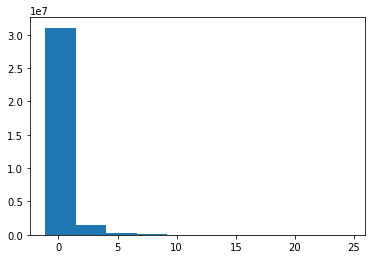

In [34]:
f,ax = plt.subplots()
ax.hist(C_z.ravel())